# gwexpy Plotting Introduction

This notebook introduces the enhanced plotting capabilities of `gwexpy`.
We demonstrate the "nice" default settings (automatic figsize adjustment, logarithmic axes, layout, axis labels) for matrix data structures such as `TimeSeriesMatrix` and `FrequencySeriesMatrix`, as well as collections like `SpectrogramList`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.frequencyseries import (
    FrequencySeries,
    FrequencySeriesList,
    FrequencySeriesMatrix,
)
from gwexpy.spectrogram import Spectrogram, SpectrogramList
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

# Fix random seed
np.random.seed(42)

/home/runner/miniconda3/envs/docs/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

## 1. TimeSeriesMatrix Plotting

`TimeSeriesMatrix` manages time series data with a 3-dimensional structure (Row, Col, Time).
When calling `.plot()`, the following optimizations are applied:
- **Axis Labels**: "Time [s]" or "Time [s] from ..." is automatically set by `determine_xlabel`.
- **Auto-GPS**: For time axes, the `auto-gps` scale is applied by default to properly handle GPS time (large offsets).
- **Layout**: The `figsize` is automatically adjusted according to the row and column structure.

In [2]:
# Create a 2x2 TimeSeriesMatrix
# 10 seconds from GPS time (e.g., 1356998418 = 2023-01-01 00:00:00 UTC)
t0 = 1356998418.0
times = t0 + np.linspace(0, 10, 1000)
data = np.random.randn(2, 2, 1000)
# Rows: Sensor A, B / Cols: Axis X, Y
tsm = TimeSeriesMatrix(
    data,
    times=times,
    unit="m",
    name="Velocity",
    rows=["Sensor A", "Sensor B"],
    cols=["X-axis", "Y-axis"],
)

# Plot
plot = tsm.plot()
plot.show()

NameError: name 'TimeSeriesMatrix' is not defined

## 2. FrequencySeriesMatrix Plotting

`FrequencySeriesMatrix` manages frequency data with a 3-dimensional structure (Row, Col, Frequency).
It typically holds results from spectral analysis.
Features of `.plot()`:
- **Logarithmic Axes**: The X-axis (frequency) and Y-axis (amplitude) are automatically set to logarithmic scale depending on conditions such as data size.
- **Axis Labels**: "Frequency [Hz]" and "[unit]" are automatically set.

In [3]:
# Create FrequencySeriesMatrix
# From 10Hz to 1kHz
f = np.logspace(1, 3, 500)
# Generate 1/f noise-like data
data = np.zeros((2, 2, 500))
for i in range(2):
    for j in range(2):
        data[i, j, :] = 10 / f * (1 + 0.1 * np.random.randn(500)) + (i + j)

# unit='m' (simplified here, though for Amplitude Spectral Density it would be m/sqrt(Hz))
fsm = FrequencySeriesMatrix(
    data,
    frequencies=f,
    unit="m",
    name="Displacement",
    rows=["Sensor A", "Sensor B"],
    cols=["X-axis", "Y-axis"],
)

# Plot
# Verify that it automatically becomes a log-log plot
plot = fsm.plot()
plot.show()

NameError: name 'FrequencySeriesMatrix' is not defined

## 3. FrequencySeriesList Plotting (Reference)

`FrequencySeriesList` (or Dict) is a simple list without a grid structure.
It can also be plotted in the same way.

In [4]:
# Create FrequencySeriesList
fs1 = FrequencySeries(1 / f, frequencies=f, unit=u.m, name="Series 1")
fs2 = FrequencySeries(2 / f, frequencies=f, unit=u.m, name="Series 2")

fs_list = FrequencySeriesList([fs1, fs2])

fs_list.plot();

NameError: name 'FrequencySeries' is not defined

In [5]:
del times, data, tsm, fsm, fs1, fs2, fs_list

import gc

gc.collect()

NameError: name 'tsm' is not defined

## 4. SpectrogramList Plotting

Plotting of `SpectrogramList` applies a vertical layout with `geometry=(N, 1)` by default, along with a logarithmic colorbar.
Since spectrograms also have a time axis, the `auto-gps` feature works when GPS time is provided.

In [6]:
# Create Spectrogram
# Use the same GPS time as TimeSeriesMatrix
t = t0 + np.linspace(0, 10, 100)
# 10Hz - 1000Hz
f = np.logspace(1, 3, 50)

spec_list = SpectrogramList(
    [
        Spectrogram(
            np.random.rand(100, 50), times=t, frequencies=f, unit=u.count, name="Spec 1"
        ),
        Spectrogram(
            np.random.rand(100, 50) * 10,
            times=t,
            frequencies=f,
            unit=u.count,
            name="Spec 2",
        ),
    ]
)
spec_list.plot();

NameError: name 'SpectrogramList' is not defined

## 4. Adaptive Plotting Optimization (Decimation)

When plotting a `TimeSeries` with a large amount of data, decimation (Min-Max Decimation) is automatically applied to maintain rendering performance.
- **Automatic Application**: By default, it is triggered when the number of samples exceeds 50,000.
- **Peak Preservation**: The Min-Max algorithm reduces the number of data points (default ~10,000 points) while preserving the waveform envelope (maximum and minimum).
- **Customization**: Can be controlled with the `decimate_threshold` and `decimate_points` arguments.

In [7]:
# Generate data with 100,000,000 samples
ts_large = TimeSeries(np.random.randn(100000000), sample_rate=1024, name="Large TS")

print(f"Original samples: {len(ts_large)}")

# Execute plot (decimation is automatically applied)
plot_opt = ts_large.plot()

# Verify the number of plotted points
ax = plot_opt.gca()
line = ax.get_lines()[0]
print(f"Plotted points: {len(line.get_xdata())}")
plot_opt.show();

NameError: name 'TimeSeries' is not defined

### Application to Collections/Matrices and Parameter Specification

It also works transparently with `TimeSeriesList` and `TimeSeriesMatrix`. You can also force it to apply by lowering the threshold.

In [8]:
# Example of lowering the threshold to 10,000 and specifying 2,000 plot points
ts_med = TimeSeries(np.random.randn(20000), sample_rate=16384, name="Medium TS")

plot_custom = ts_med.plot(decimate_threshold=10000, decimate_points=2000)

ax = plot_custom.gca()
print(f"Original: {len(ts_med)}, Plotted: {len(ax.get_lines()[0].get_xdata())}")
plot_custom.show();

NameError: name 'TimeSeries' is not defined

## 5. Spectrogram Summary Plotting

`plot_summary` is a feature that vertically arranges multiple `Spectrogram` objects and plots `FrequencySeries` statistics (10%, 50%, 90% percentiles) on the right side of each.
This is very useful when checking the time evolution of spectrograms alongside their overall frequency characteristics.

- **Automatic Synchronization**: The color axis of the spectrogram and the vertical axis of the FrequencySeries are automatically synchronized.
- **MMM Plot**: Uses `plot_mmm` to display Min/Median/Max (or any percentiles) with shaded areas.

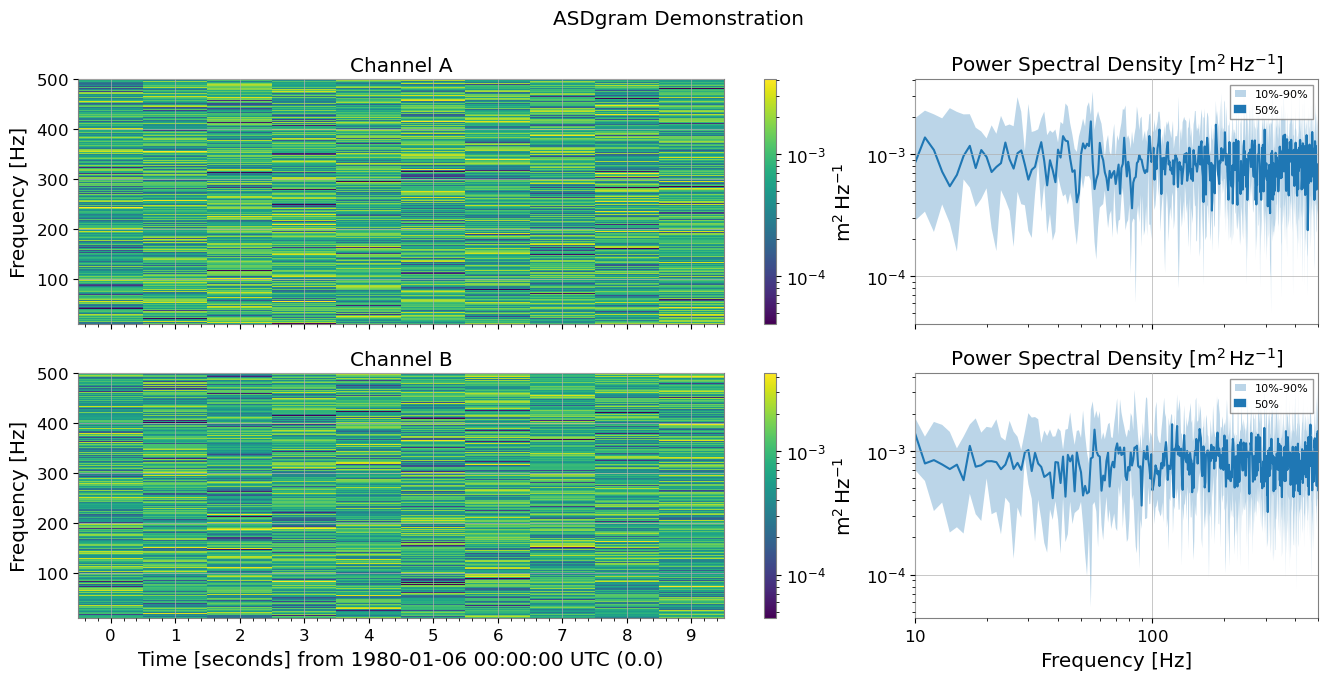

In [9]:
from gwexpy.spectrogram import SpectrogramDict
from gwexpy.timeseries import TimeSeries


# Generate test data
def make_sg(name):
    ts = TimeSeries(np.random.randn(2048 * 10), sample_rate=2048, name=name, unit="m")
    return ts.spectrogram(stride=1, fftlength=1, overlap=0.5)


sg_dict = SpectrogramDict({"Channel A": make_sg("A"), "Channel B": make_sg("B")})

# Execute ASDgram plot
fig, axes = sg_dict.plot_summary(fmin=10, fmax=500, title="ASDgram Demonstration")
plt.show();

## 6. PairPlot Example

Below is a basic usage example of `gwexpy.plot.PairPlot`.
- Create two `TimeSeries` with different sampling rates
- `PairPlot` automatically resamples to the minimum sample rate and trims to the common interval
- With `corner=True` (default), only the lower-left triangle is drawn

When executed, histograms appear on the diagonal and 2D histograms on the off-diagonal.

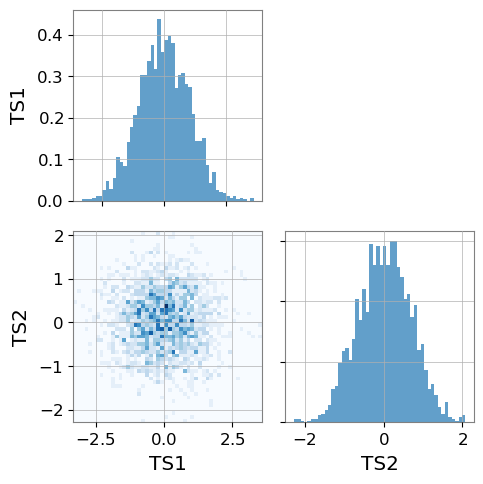

In [10]:
import numpy as np

from gwexpy.plot import PairPlot
from gwexpy.timeseries import TimeSeries

# Create two TimeSeries with different sampling rates
ts1 = TimeSeries(np.random.randn(5000), sample_rate=1024, name="TS1")
ts2 = TimeSeries(np.random.randn(4000), sample_rate=2048, name="TS2")

# Create PairPlot (corner=True is default)
pair = PairPlot([ts1, ts2], corner=True)

# Display
pair.show()